Previous Tutorial: https://www.youtube.com/watch?v=ny215UUXbhI&t=501s

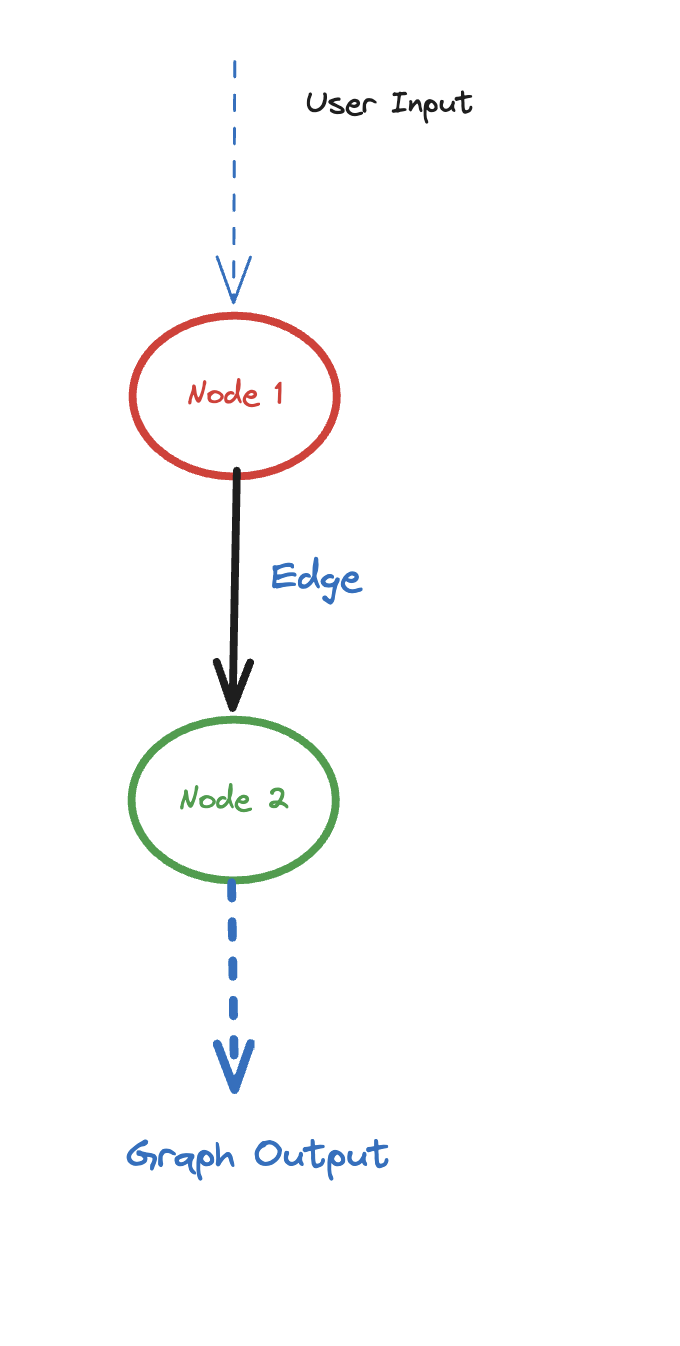

In [3]:
from IPython.display import Image
Image(filename='LG_1.png',width=400)

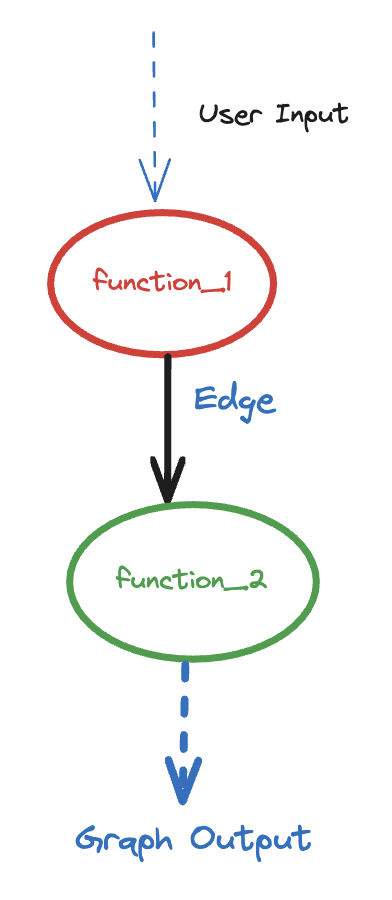

In [4]:
from IPython.display import Image
Image(filename='LG_2.png',width=300) 

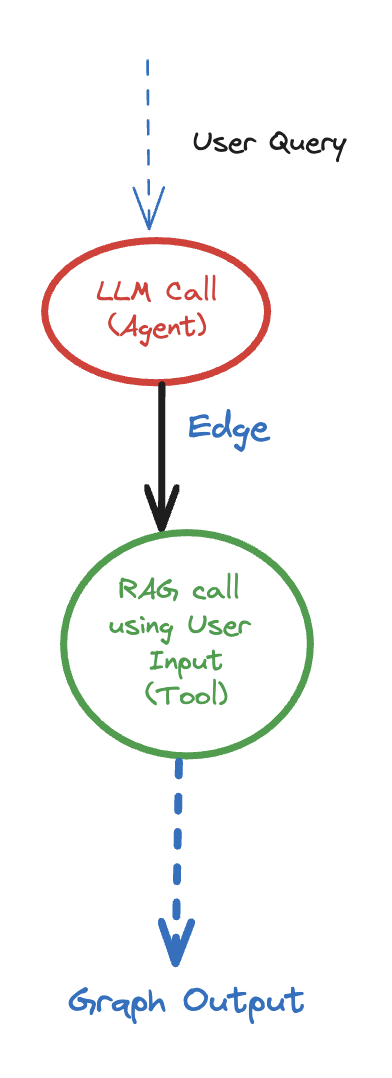

In [5]:
from IPython.display import Image
Image(filename='LG_4.png',width=200) 

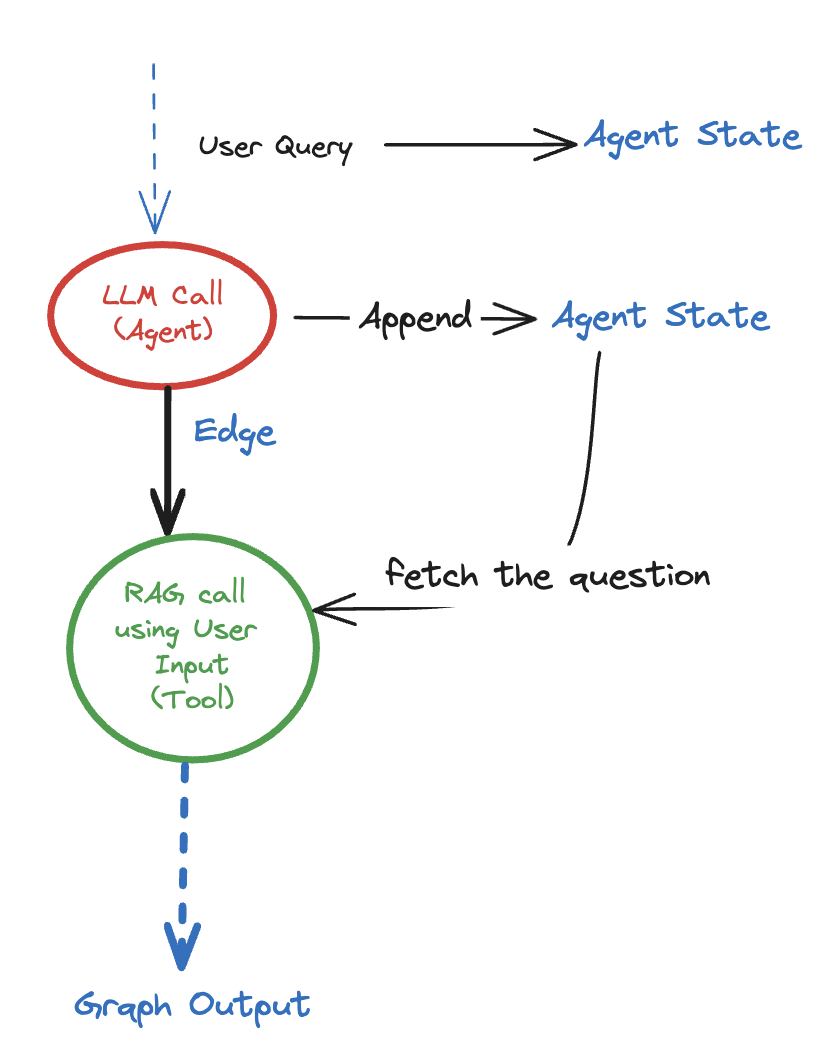

In [6]:
from IPython.display import Image
Image(filename='LG_5.png',width=400)

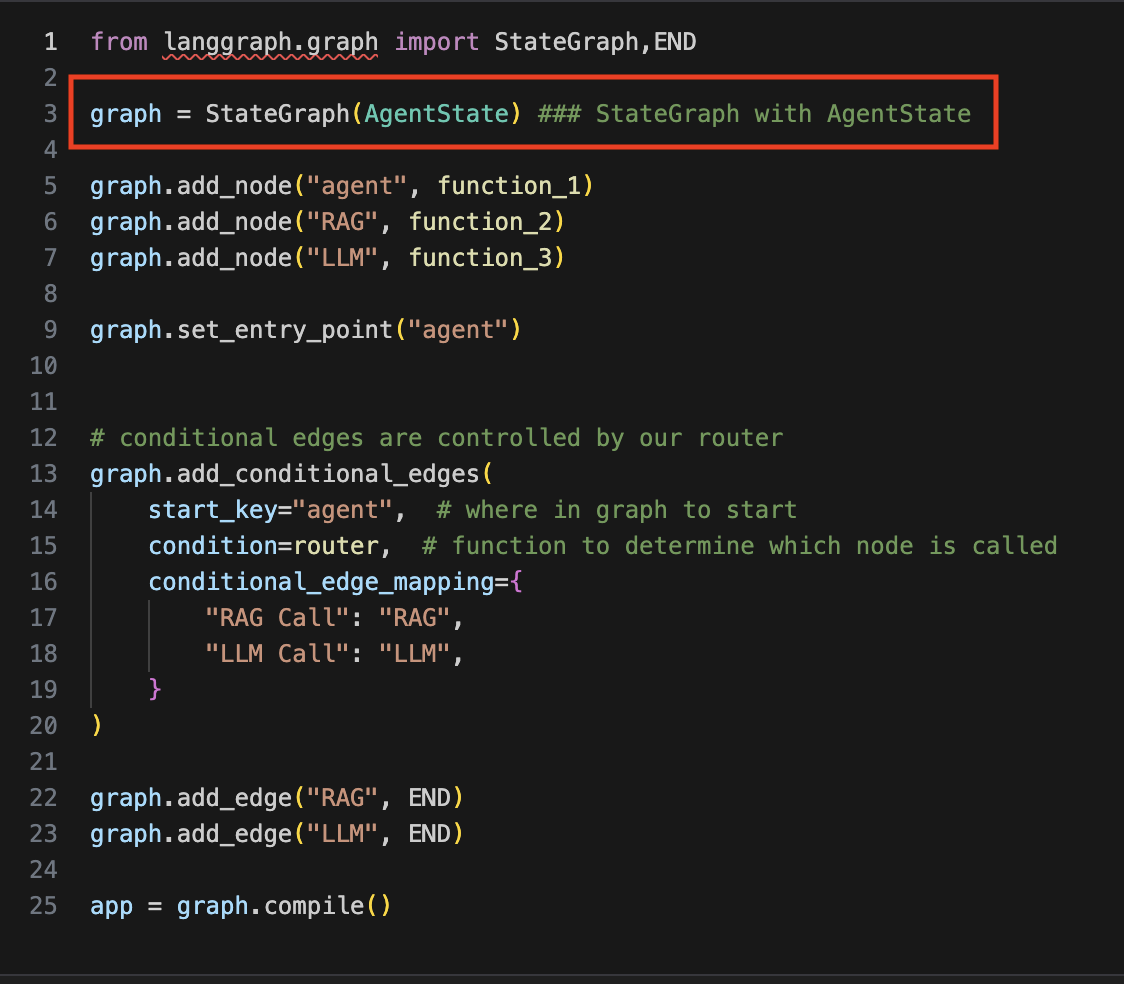

In [7]:
from IPython.display import Image
Image(filename='LG_StateGraph.png',width=500)

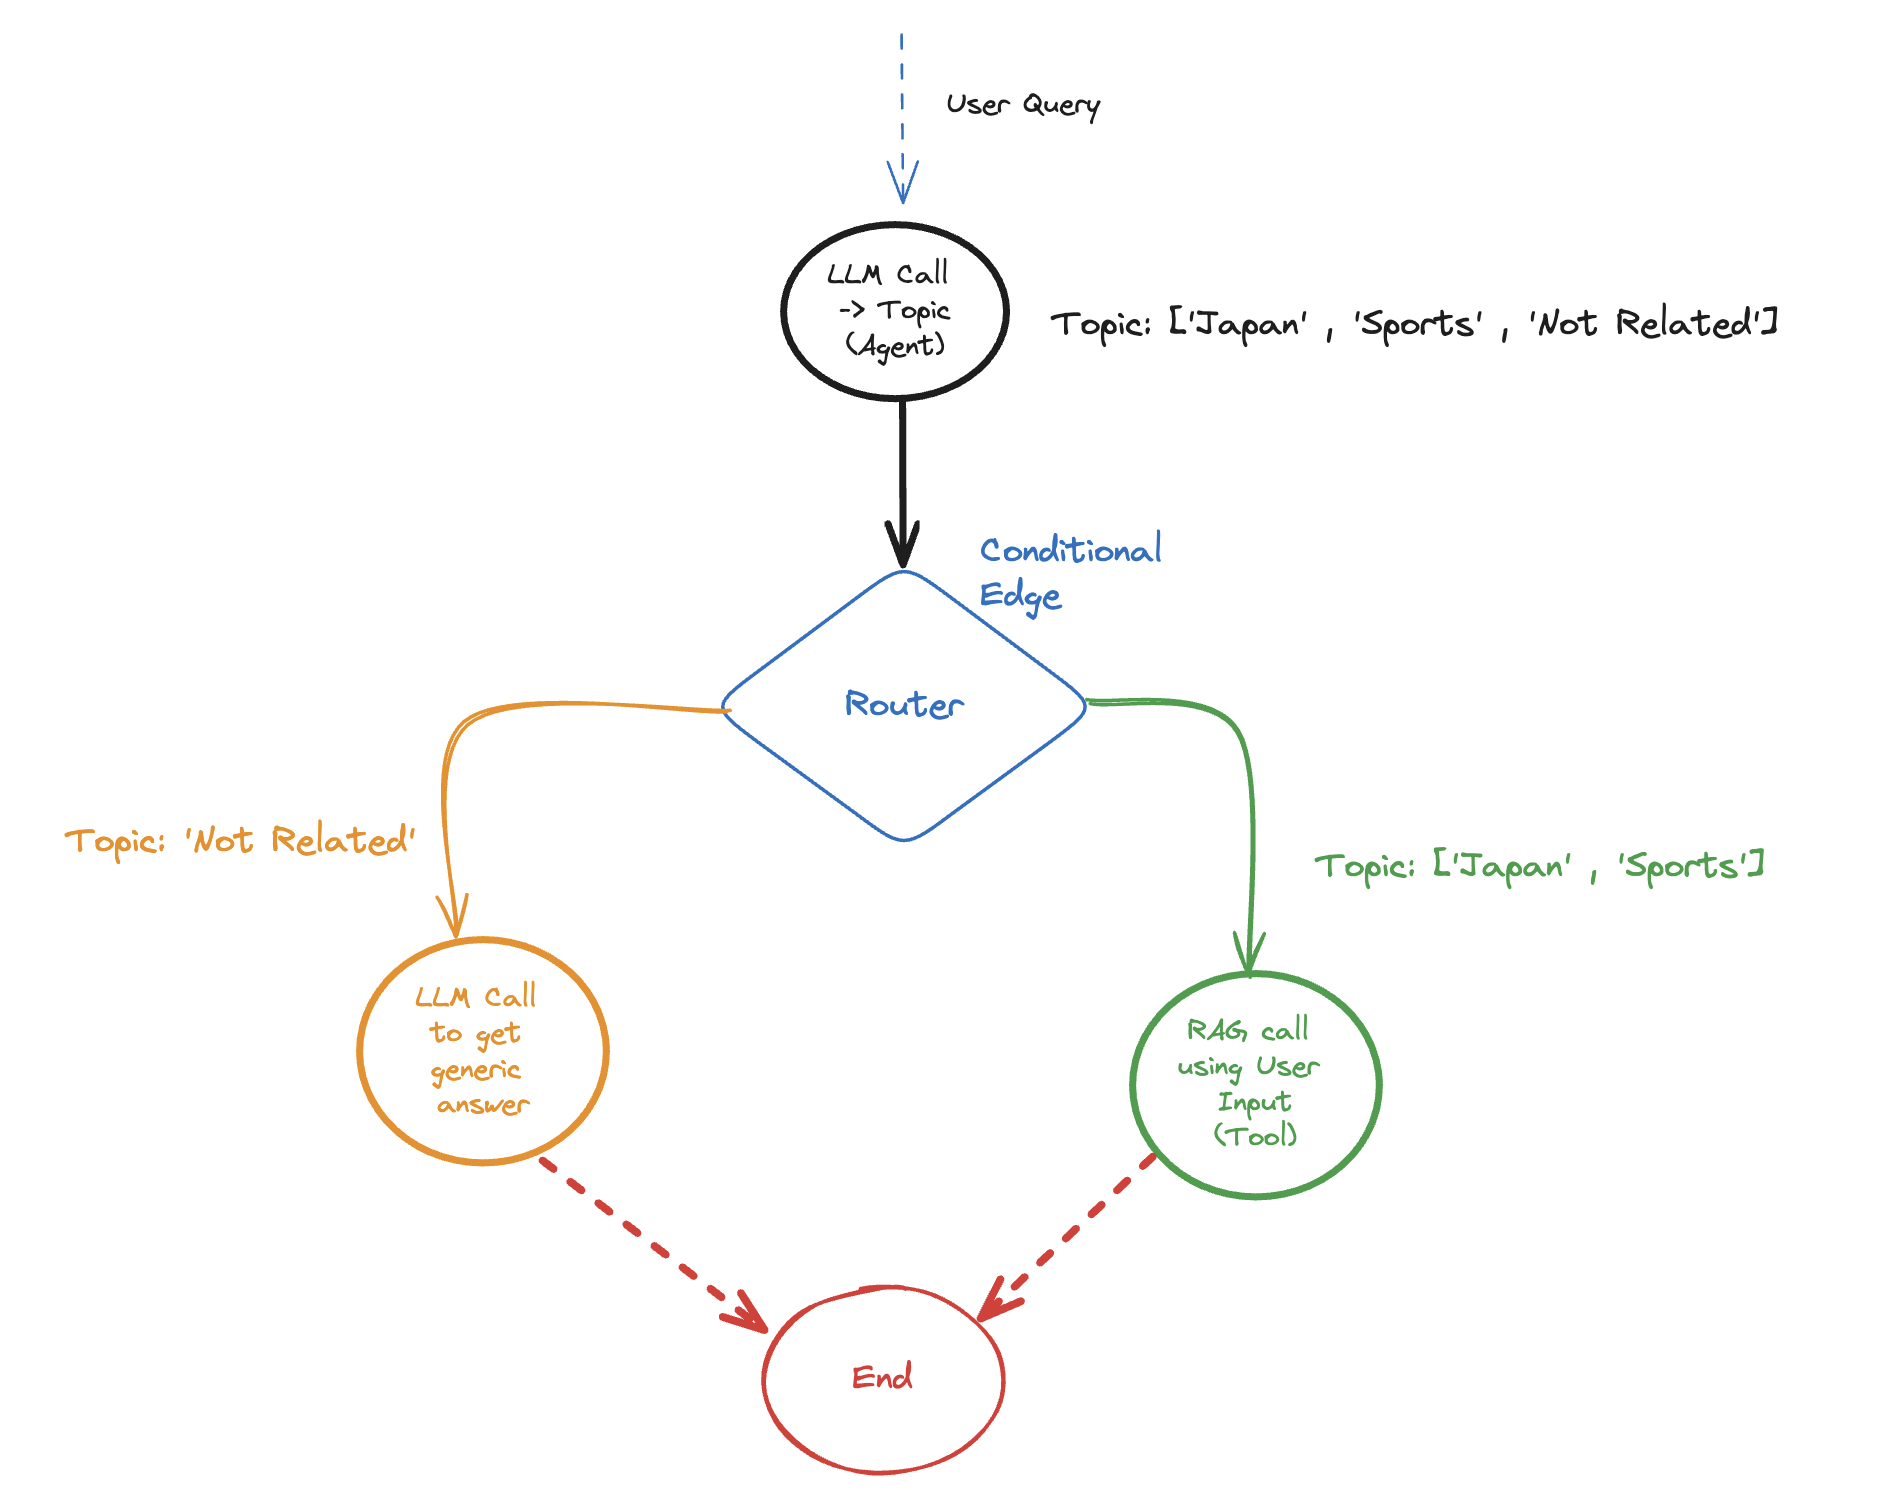

In [8]:
from IPython.display import Image
Image(filename='LG_6.png',width=800)

### Importing the LLM

In [3]:
import os
from dotenv import load_dotenv

load_dotenv()


from langchain_openai import ChatOpenAI

# Now you can access your environment variables using os.environ
os.environ['OPENAI_API_KEY'] = os.environ.get("OPENAI_API_KEY")


model = ChatOpenAI(temperature=0)

In [4]:
model.invoke('Hi')

AIMessage(content='Hello! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3b956da36b', 'finish_reason': 'stop', 'logprobs': None}, id='run-e016c213-54a2-4e1c-825f-7406690cde63-0')

### Bind tool with LLM

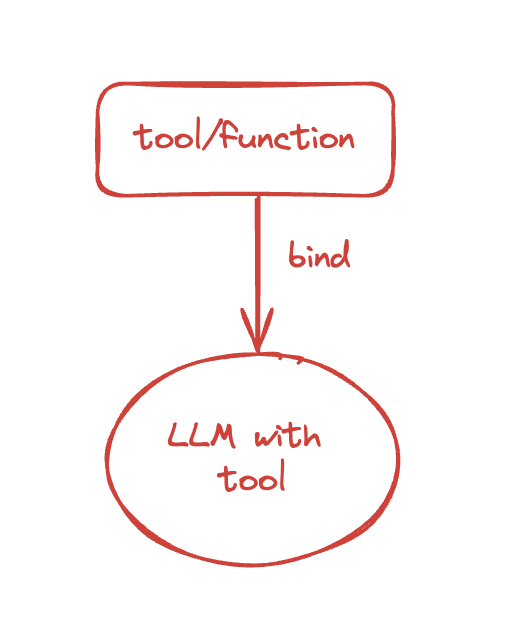

In [29]:
from IPython.display import Image
Image(filename='LG_7.png',width=500)

In [5]:
import json
from langchain_core.messages import ToolMessage
from langchain_core.tools import tool
from langchain_core.utils.function_calling import convert_to_openai_tool

@tool
def multiply(first_number: int, second_number: int):
    """Multiplies two numbers together."""
    return first_number * second_number

model_with_tools = model.bind(tools=[convert_to_openai_tool(multiply)])

In [6]:
response = model_with_tools.invoke('What is 35 * 46?')

In [7]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_WMdrOFgOOCgcMXSwjlnjZB0l', 'function': {'arguments': '{"first_number":35,"second_number":46}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 69, 'total_tokens': 88}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3b956da36b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-84f6e82d-8813-43de-b152-d9694a5fe73e-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 35, 'second_number': 46}, 'id': 'call_WMdrOFgOOCgcMXSwjlnjZB0l'}])

In [8]:
tool_calls = response.additional_kwargs.get('tool_calls')
tool_calls

[{'id': 'call_WMdrOFgOOCgcMXSwjlnjZB0l',
  'function': {'arguments': '{"first_number":35,"second_number":46}',
   'name': 'multiply'},
  'type': 'function'}]

In [9]:
type(tool_calls)

list

In [10]:
for tool_call in tool_calls:
    print('Function Name:',tool_call.get('function').get('name'))
    print('Function Arguments:',tool_call.get('function').get('arguments'))
    print(tool_call)

Function Name: multiply
Function Arguments: {"first_number":35,"second_number":46}
{'id': 'call_WMdrOFgOOCgcMXSwjlnjZB0l', 'function': {'arguments': '{"first_number":35,"second_number":46}', 'name': 'multiply'}, 'type': 'function'}


### Building the Graph with conditional edge and tool calling

In [11]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

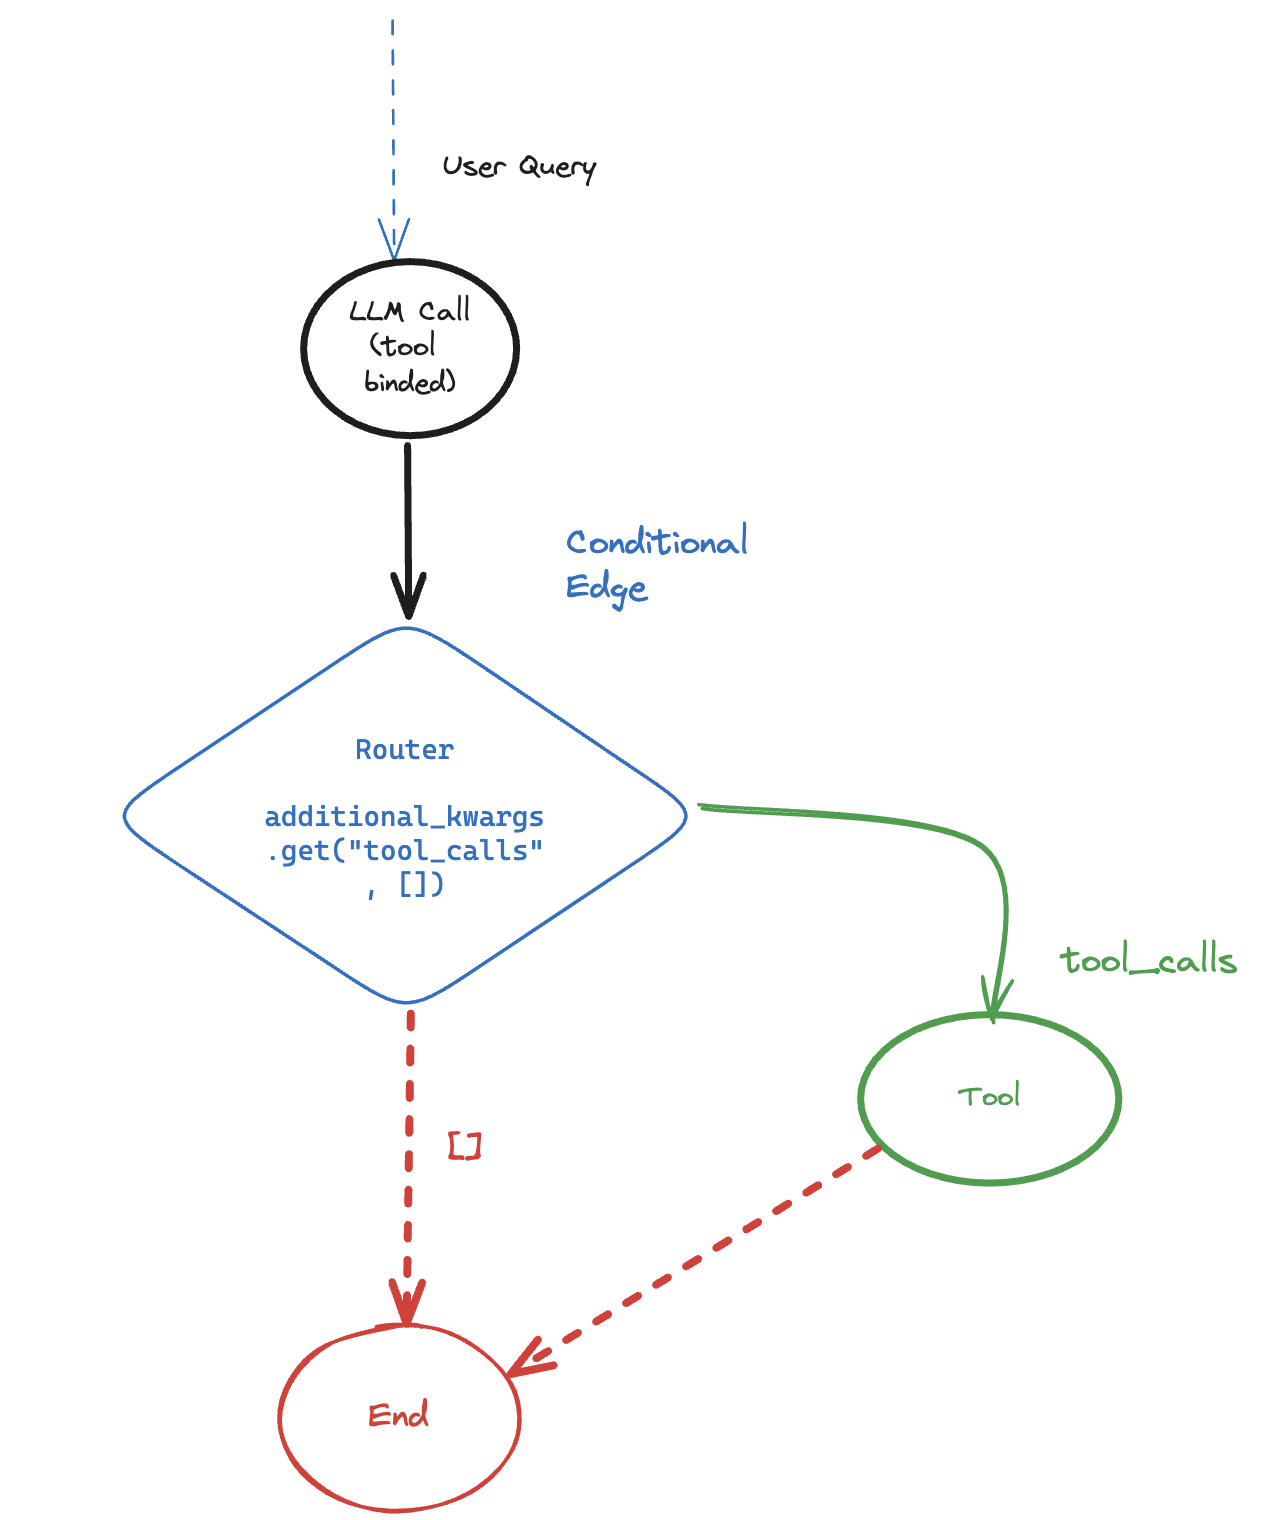

In [31]:
from IPython.display import Image
Image(filename='LG_8.png',width=700)

In [15]:
from langgraph.graph import StateGraph,END

graph = StateGraph(AgentState) ### StateGraph with AgentState


def invoke_model(state):
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question
    return {"messages":[model_with_tools.invoke(question)]}


graph.add_node("agent", invoke_model)

def invoke_tool(state):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    multiply_call = None

    for tool_call in tool_calls:
        if tool_call.get("function").get("name") == "multiply":
            multiply_call = tool_call

    if multiply_call is None:
        raise Exception("No adder input found.")

    res = multiply.invoke(
        json.loads(multiply_call.get("function").get("arguments"))
    )

    return {"messages" : [res]
    }

graph.add_node("tool", invoke_tool)

graph.add_edge("tool", END)

graph.set_entry_point("agent")

In [16]:
def router(state):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "multiply"
    else:
        return "end"

graph.add_conditional_edges("agent", router, {
    "multiply": "tool",
    "end": END,
})

In [18]:
app = graph.compile()

output = app.invoke({"messages": ["What is 123 * 456?"]})

In [19]:
output

{'messages': ['What is 123 * 456?',
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tbPITOMiampzlJRH6jyTt5Hc', 'function': {'arguments': '{"first_number":123,"second_number":456}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 69, 'total_tokens': 88}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3b956da36b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-94c2ae10-86b1-4743-9630-f34fbdcdc905-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 123, 'second_number': 456}, 'id': 'call_tbPITOMiampzlJRH6jyTt5Hc'}]),
  56088]}

In [23]:
output['messages'][-1]

56088

In [24]:
output = app.invoke({"messages": ["What is LLM?"]})

In [25]:
output

{'messages': ['What is LLM?',
  AIMessage(content='LLM stands for Language Model. A language model is a statistical model that is used to predict the probability of a sequence of words or characters in a language. It is commonly used in natural language processing tasks such as speech recognition, machine translation, and text generation. Language models are trained on large amounts of text data to learn the patterns and relationships between words in a language.', response_metadata={'token_usage': {'completion_tokens': 76, 'prompt_tokens': 66, 'total_tokens': 142}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3b956da36b', 'finish_reason': 'stop', 'logprobs': None}, id='run-7b50e7b1-f050-422e-b008-fa406c6bc311-0')]}

In [27]:
print(output['messages'][-1])

content='LLM stands for Language Model. A language model is a statistical model that is used to predict the probability of a sequence of words or characters in a language. It is commonly used in natural language processing tasks such as speech recognition, machine translation, and text generation. Language models are trained on large amounts of text data to learn the patterns and relationships between words in a language.' response_metadata={'token_usage': {'completion_tokens': 76, 'prompt_tokens': 66, 'total_tokens': 142}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3b956da36b', 'finish_reason': 'stop', 'logprobs': None} id='run-7b50e7b1-f050-422e-b008-fa406c6bc311-0'
